In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the Winner Take All units
class WTU(object):
  def __init__(self, m, n, dim, num_iterations, eta = 0.5, sigma = None):
    self._m = m
    self._n = n
    self._neighbourhood = []
    self._topography = []
    self._num_iterations = int(num_iterations) 
    self._learned = False
    self.dim = dim
    
    self.eta = float(eta)
        
    if sigma is None:
        sigma = max(m,n)/2.0    # Constant radius
    else:
        sigma = float(sigma)
    self.sigma = sigma
    
        
    print('Network created with dimensions',m,n)
        
    # Weight Matrix and the topography of neurons
    self._W = tf.random.normal([m*n, dim], seed = 0)
    self._topography = np.array(list(self._neuron_location(m, n)))
          
  def training(self,x, i):
    m = self._m
    n= self._n 
    
    # Finding the Winner and its location
    d = tf.sqrt(tf.reduce_sum(tf.pow(self._W - tf.stack([x for i in range(m*n)]),2),1))
    self.WTU_idx = tf.argmin(d,0)
    
    slice_start = tf.pad(tf.reshape(self.WTU_idx, [1]),np.array([[0,1]]))
    self.WTU_loc = tf.reshape(tf.slice(self._topography, slice_start,[1,2]), [2])
    
    
    # Change learning rate and radius as a function of iterations
    learning_rate = 1 - i/self._num_iterations
    _eta_new = self.eta * learning_rate
    _sigma_new = self.sigma * learning_rate
    
    
    # Calculating Neighbourhood function
    distance_square = tf.reduce_sum(tf.pow(tf.subtract(
        self._topography, tf.stack([self.WTU_loc for i in range(m * n)])), 2), 1)
    neighbourhood_func = tf.exp(tf.negative(tf.math.divide(tf.cast(
        distance_square, "float32"), tf.pow(_sigma_new, 2))))
    
    # multiply learning rate with neighbourhood func
    eta_into_Gamma = tf.multiply(_eta_new, neighbourhood_func)
    
    # Shape it so that it can be multiplied to calculate dW
    weight_multiplier = tf.stack([tf.tile(tf.slice(
        eta_into_Gamma, np.array([i]), np.array([1])), [self.dim])
        for i in range(m * n)])
    delta_W = tf.multiply(weight_multiplier,
        tf.subtract(tf.stack([x for i in range(m * n)]),self._W))
    new_W = self._W + delta_W
    self._W = new_W
            
           
  def fit(self, X):
    for i in range(self._num_iterations):
        for x in X:
              self.training(x,i)
        
    
    
    # Store a centroid grid for easy retrieval
    centroid_grid = [[] for i in range(self._m)]
    self._Wts = list(self._W)
    self._locations = list(self._topography)
    for i, loc in enumerate(self._locations):
        centroid_grid[loc[0]].append(self._Wts[i])
    self._centroid_grid = centroid_grid

    self._learned = True
    
  def winner(self, x):
    idx = self.WTU_idx,self.WTU_loc
    return idx
             
  def _neuron_location(self,m,n):
        
    for i in range(m):
        for j in range(n):
            yield np.array([i,j])
                
                
  def get_centroids(self):
       
    if not self._learned:
        raise ValueError("SOM not trained yet")
    return self._centroid_grid

  def map_vects(self, X):
       

    if not self._learned:
        raise ValueError("SOM not trained yet")

    to_return = []
    for vect in X:
        min_index = min([i for i in range(len(self._Wts))],
                        key=lambda x: np.linalg.norm(vect -
                                                      self._Wts[x]))
        to_return.append(self._locations[min_index])

    return to_return

In [ ]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result.astype(np.float32)



In [ ]:
!wget https://raw.githubusercontent.com/PacktPublishing/Deep-Learning-with-TensorFlow-2-and-Keras/master/Chapter%2010/colors.csv

--2022-02-04 23:20:10--  https://raw.githubusercontent.com/PacktPublishing/Deep-Learning-with-TensorFlow-2-and-Keras/master/Chapter%2010/colors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 269 [text/plain]
Saving to: ‘colors.csv’

colors.csv          100%[===================>]     269  --.-KB/s    in 0s      

2022-02-04 23:20:10 (12.1 MB/s) - ‘colors.csv’ saved [269/269]



In [ ]:
## Reading input data from file
import pandas as pd

df = pd.read_csv('colors.csv')  # The last column of data file is a label
data = normalize(df[['R', 'G', 'B']]).values
name = df['Color-Name'].values
n_dim = len(df.columns) - 1

In [ ]:
# Data for Training
colors = data
color_names = name

In [ ]:
%%time
som = WTU(30, 30, n_dim, 400, sigma=10.0)
som.fit(colors)

Network created with dimensions 30 30
CPU times: user 1h 13min 56s, sys: 11min 38s, total: 1h 25min 35s
Wall time: 1h 5min 6s


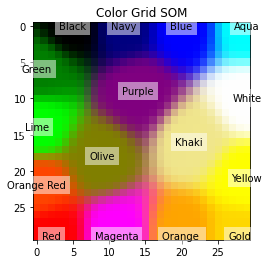

In [ ]:
# Get output grid
image_grid = som.get_centroids()

# Map colours to their closest neurons
mapped = som.map_vects(colors)

# Plot
plt.imshow(image_grid)
plt.title('Color Grid SOM')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], color_names[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))

In [ ]:
idx, loc = som.winner([0.5, 0.5, 0.5])
print(idx, loc)


tf.Tensor(501, shape=(), dtype=int64) tf.Tensor([16 21], shape=(2,), dtype=int64)
